In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import argparse
from collections import OrderedDict

import yaml
import csv
import time
from datetime import datetime
import shutil
import logging
from typing import Tuple, Sequence, Any, Union
from functools import partial

from jax import random
import jax.numpy as jnp
import jax
from brax.io import html
from brax import jumpy as jp
from brax import envs
from IPython.display import HTML

os.environ['CUDA_VISIBLE_DEVICES'] = ''

import evojax
from evojax.util import get_params_format_fn
from evojax.task.base import TaskState
from evojax.policy.base import PolicyState
from evojax.policy.base import PolicyNetwork
from evojax.task.seq_task import SeqTask
from flax.struct import dataclass
from flax import linen as nn

from evojax.task.brax_task import BraxTask
from evojax.task.gym_task import Gym
from evojax.algo import PGPE, OpenES
from evojax import ObsNormalizer
from evojax import SimManager
from evojax.task.cue_reward_task import CueRewardTask
import mediapy as media

sns.set_style('darkgrid')
sns.set_palette('muted', desat=.6)
sns.set_context("notebook", font_scale=1.0,
                rc={"lines.linewidth": 2.5})

output_dir = '/home/floyed/evojax/examples/metaplasticity_plot'

2023-07-17 15:42:00.132468: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Seq_length: 8, Latency: 0
Plasticity:
0.99054222
0.021148238996237946
Weight:
0.9923264166666668
0.018796363665391932
Seq_length: 8, Latency: 8
Plasticity:
0.9156749679999999
0.010748799367609389
Weight:
0.8829994266666668
0.05618404151990729
Seq_length: 8, Latency: 16
Plasticity:
0.8825439420000001
0.01110670251055507
Weight:
0.7885856616666667
0.1467975815370227
Seq_length: 8, Latency: 32
Plasticity:
0.78257446
0.028871715251417806
Weight:
0.6713924383333333
0.08784965252700945
Seq_length: 16, Latency: 0
Plasticity:
0.941438472
0.012445502075387324
Weight:
0.78518735
0.17418278071560347
Seq_length: 16, Latency: 8
Plasticity:
0.7963312140000001
0.040177745470154
Weight:
0.822202488
0.0052145948498152975
Seq_length: 16, Latency: 16
Plasticity:
0.8039228420000001
0.017410944798892165
Weight:
0.7525575680000001
0.028304444783105526
Seq_length: 16, Latency: 32
Plasticity:
0.642692184
0.13649159447175446
Weight:
0.582522196
0.11327262624967928
Seq_length: 32, Latency: 0
Plasticity:
0.80135

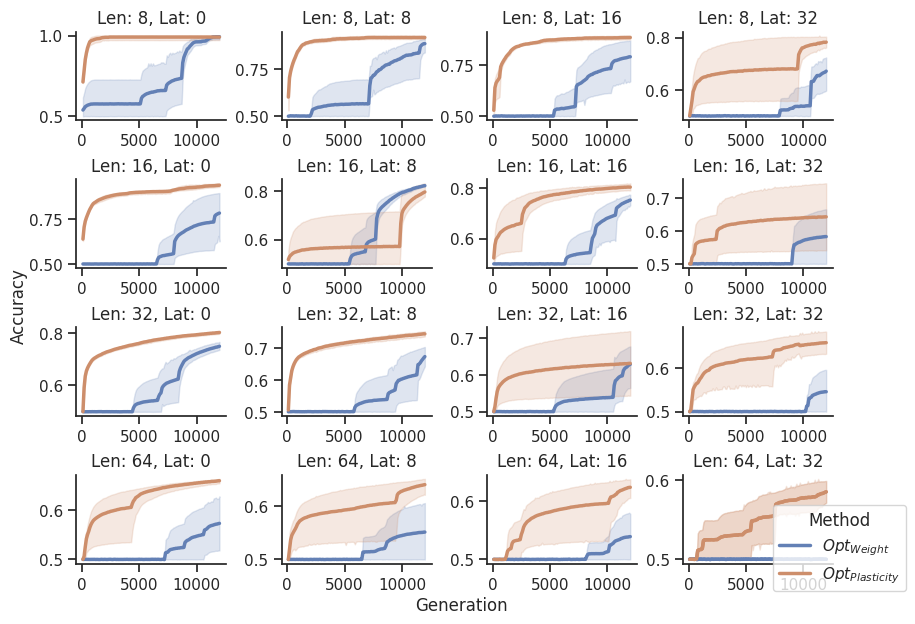

In [84]:
root_dir = './logs/working_memory'
meta_fname = [
    'PGPE-BatchedGruMetaStdpMLPPolicy-SeqTask--20230707-000444',
    'PGPE-BatchedGruMetaStdpMLPPolicy-SeqTask--20230707-135859',
    'PGPE-BatchedGruMetaStdpMLPPolicy-SeqTask--20230707-135906',
    'PGPE-BatchedGruMetaStdpMLPPolicy-SeqTask--20230707-135823',
]

base_fname = [
    'PGPE-GruPolicy-SeqTask--20230707-000522',
    'PGPE-GruPolicy-SeqTask--20230707-135926',
    'PGPE-GruPolicy-SeqTask--20230707-135934',
    'PGPE-GruPolicy-SeqTask--20230707-135829',
]

meta_dir = [os.path.join(root_dir, fname) for fname in meta_fname]
base_dir = [os.path.join(root_dir, fname) for fname in base_fname]

fig = plt.figure(figsize=(9, 6), dpi=100, constrained_layout=True)
spec = fig.add_gridspec(nrows=5, ncols=5, figure=fig, width_ratios=[0.1, 1, 1, 1, 1], height_ratios=[1, 1, 1, 1, 0.1])

data = []
for fname in base_dir:
    df = pd.read_csv(os.path.join(fname, 'summary.csv'))
    df['Score'] = df['score_avg']
    df['episode'] = df['epoch']
    df['Method'] = '$Opt_{Weight}$'
    data.append(df)

for fname in meta_dir:
    df = pd.read_csv(os.path.join(fname, 'summary.csv'))
    df['Score'] = df['score_avg']
    df['episode'] = df['epoch']
    df['Method'] = '$Opt_{Plasticity}$'
    data.append(df)

data = pd.concat(data)
data.drop(data[data['epoch'] == 'epoch'].index, inplace=True)
data[['epoch', 'seq_length', 'latency', 'episode']] = data[['epoch', 'seq_length', 'latency', 'episode']].astype(int)
data[['score_avg', 'score_best', 'score_std', 'Score']] = data[['score_avg', 'score_best', 'score_std', 'Score']].astype(float)
data = data.reset_index(drop=True)

r, c = 0, 0
for seq_length in [8, 16, 32, 64]:
    for latency in [0, 8, 16, 32]:
        print('Seq_length: {}, Latency: {}'.format(seq_length, latency))
        print('Plasticity:')
        print(data[(data['epoch'] == 11999) & (data['Method'] == '$Opt_{Plasticity}$') & (data['seq_length'] == seq_length) & (data['latency'] == latency)]['Score'].mean())
        print(data[(data['epoch'] == 11999) & (data['Method'] == '$Opt_{Plasticity}$') & (data['seq_length'] == seq_length) & (data['latency'] == latency)]['Score'].std())
        print('Weight:')
        print(data[(data['epoch'] == 11999) & (data['Method'] == '$Opt_{Weight}$') & (data['seq_length'] == seq_length) & (data['latency'] == latency)]['Score'].mean())
        print(data[(data['epoch'] == 11999) &( data['Method'] == '$Opt_{Weight}$') & (data['seq_length'] == seq_length) & (data['latency'] == latency)]['Score'].std())

        ax = fig.add_subplot(spec[r, c + 1])
        if r == 3 and c == 3:
            g = sns.lineplot(data=data[(data['seq_length'] == seq_length) & (data['latency'] == latency)], x='episode', y='Score', hue='Method', legend='auto')
        sns.lineplot(data=data[(data['seq_length'] == seq_length) & (data['latency'] == latency)], x='episode', y='Score', hue='Method', legend=None)
        sns.despine()
        plt.xlabel('')
        plt.ylabel('')
        plt.title('Len: {}, Lat: {}'.format(seq_length, latency))
        # plt.xlim(0, 11999)
        # plt.ylim(.5, 1.)
        sns.set_style("ticks")

        c = (c + 1) % 4
    r += 1

sns.move_legend(g, "upper left", bbox_to_anchor=(.55, .75))
fig.text(0.45, 0.0, 'Generation', va='center')
fig.text(0.0, 0.5, 'Accuracy', va='center', rotation='vertical')
# fig.text(0.0, 1.0, 'Seq_len / Latency', va='center')
plt.savefig(os.path.join(output_dir, 'memory_vis.pdf'), format='pdf', bbox_inches='tight')
plt.show()

In [2]:
def load_model(model_dir: str, fname='best.npz') -> Tuple[np.ndarray, np.ndarray, int, float, int]:
    model_file = os.path.join(model_dir, fname)
    if not os.path.exists(model_file):
        raise ValueError('Model file {} does not exist.')
    with np.load(model_file, allow_pickle=True) as data:
        params = data['params']
        obs_params = data['obs_params']
        epoch = data.get('epoch', 0)
        score = data.get('score', -float('Inf'))
        steps = data.get('steps', 0)
    return params, obs_params, epoch, score, steps

In [3]:
def generate(seq, seq_length=8, latency=16, batch_size=1):
    mem = jnp.array(seq).reshape(1, -1)
    a = jnp.concatenate([
        mem,
        jnp.zeros((batch_size, latency + seq_length + 1)),
    ], axis=1)
    b = jnp.concatenate([
        jnp.ones((batch_size, seq_length)),
        jnp.zeros((batch_size, latency + seq_length + 1))
    ], axis=1)
    c = jnp.concatenate([  # act as output mask
        jnp.zeros((batch_size, seq_length + latency)),
        jnp.ones((batch_size, seq_length)),
        jnp.zeros((batch_size, 1)),
    ], axis=1)
    seq_input = jnp.stack([a, b, c], axis=2)  # batch, step, dim

    seq_output = jnp.concatenate([
        jnp.zeros((batch_size, seq_length + latency)),
        mem,
        jnp.zeros((batch_size, 1)),
    ], axis=1)
    return seq_input[None, :], seq_output[None, :]

In [75]:
def eval_with_injury(seq, policy, obs_normalizer, params, obs_params, plot=True, seed=42, algo='stdp', reset=False):
    seq_input, seq_output = seq
    env = SeqTask(
            seq_length=8,
            latency=16,
            batch_size=1,
            test=False
    )
    # state = env.reset(rng=jp.random_prngkey(seed=0))
    task_reset_fn = jax.jit(env.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(env.step)
    act_fn = jax.jit(policy.get_actions)
    # update_fn = jax.jit(policy.update_fn) if hasattr(policy, 'update_fn') else lambda params, p_state, t_state: p_state
    # obs_norm_fn = jax.jit(obs_normalizer.normalize_obs)

    total_reward = 0
    rollout = []
    rewards = []
    ws = []
    traces = []
    rng = jax.random.PRNGKey(seed + 1)
    task_state = task_reset_fn(key=rng.reshape(1, 2))
    task_state = task_state.replace(obs=seq_input[:, :, 0], step=np.array([0]), inputs=seq_input, outputs=seq_output)
    policy_state = policy_reset_fn(task_state)
    step = 0
    done = False
    while not done:
    # while step < len(ctrl) if ctrl else 1000:
    #     task_state = task_state.replace(
    #         obs=obs_norm_fn(task_state.obs[None, :], obs_params))
        rollout.append(task_state)
        traces.append(policy_state.traces[0])
        # jax.debug.breakpoint()
        act, policy_state = act_fn(task_state, params[None, :], policy_state)

        # For 50 steps, completely zero out the weights to see if the policy can
        # relearn weights that allow the ant to walk.
        if reset and step in list(range(8, 24)):
            policy_state.mem_status[0] = jnp.zeros_like(policy_state.mem_status[0])
            policy_state.carrys[0] = jnp.zeros_like(policy_state.carrys[0])
            policy_state.traces[0] = jnp.zeros_like(policy_state.traces[0])
        # jax.debug.breakpoint()
        # task_state = task_state.replace(obs=task_state.obs[0])
        task_state, reward, done = step_fn(task_state, act)
        # task_state = env.step(task_state, act[0])
        # policy_state = update_fn(params[None, :], policy_state, None)
        total_reward = total_reward + reward
        rewards.append(reward)
        # Record the weights every 10 steps for visualisations.
        if hasattr(policy_state, 'fast_Ws'):
            ws.append(policy_state.fast_Ws)
        step += 1

        if step % 100 == 0 and plot:
            print('[Eval with injury] {}, reward:{:.3e}'.format(step, total_reward))
    print('[Eval with injury] rollout reward = {}'.format(total_reward))

    ww = []
    if ws:
        ws = list(zip(*ws))
        for i, w in enumerate(ws):
            w = jnp.concatenate(w)
            # print(w.shape)
            if plot:
                media.show_video(w, height=w.shape[1] * 4, codec='gif', fps=5)
                media.write_video(os.path.join(output_dir, '{}.gif'.format(i)), w, codec='gif', fps=5)
            ww.append(w)
            # fig, ax = plt.subplots()
            # ax.plot(np.cumsum(np.array(rewards)))
            # plt.savefig(os.path.join(output_dir, 'SeqLearning_{}.pdf').format(algo))

    return rewards, rollout, ww, traces

In [36]:
# /data/floyed/meta/train/PGPE-BatchedGruMetaStdpMLPPolicy-SeqTask--20230706-212038
resume = '/data/floyed/meta/train/PGPE-BatchedGruMetaStdpMLPPolicy-SeqTask--20230708-133314'
hidden_dims = [128]

train_task = SeqTask(
    seq_length=8,
    latency=16,
    batch_size=1,
    test=False
)
policy = getattr(evojax.policy, 'BatchedGruMetaStdpMLPPolicy')(
    input_dim=train_task.obs_shape[0],
    hidden_dims=[
        *hidden_dims,
    ],
    output_dim=train_task.act_shape[0],
)

best_params, obs_params, epoch, best_score, steps = load_model(model_dir=resume)
obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape, dummy=True)

(3,)


[Eval with injury] rollout reward = [1.]


""


""


<Axes: >

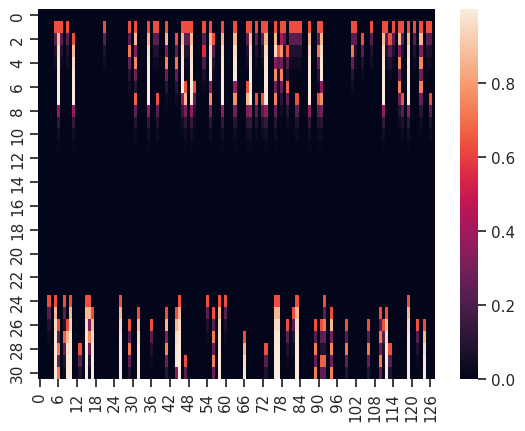

In [37]:
seq = generate([1, 1, 0, 0, 0, 0, 1, 1])
meta_rewards, meta_rollouts, meta_weight, meta_traces = eval_with_injury(seq, policy, obs_normalizer, best_params, obs_params, plot=True, seed=41)
meta_traces = np.array(meta_traces[1:]).reshape(31, -1)
sns.heatmap(np.abs(meta_traces))

In [38]:
# /data/floyed/meta/train/PGPE-BatchedGruMLPPolicy-SeqTask--20230707-162644
resume = '/data/floyed/meta/train/PGPE-BatchedGruMLPPolicy-SeqTask--20230708-133249'
# resume = '/data/floyed/meta/train/PGPE-BatchedGruMLPPolicy-SeqTask--20230707-212239'  # use_bias = False
hidden_dims = [128]

train_task = SeqTask(
    seq_length=8,
    latency=16,
    batch_size=1,
    test=False
)
policy = getattr(evojax.policy, 'BatchedGruMLPPolicy')(
    input_dim=train_task.obs_shape[0],
    hidden_dims=[
        *hidden_dims,
    ],
    output_dim=train_task.act_shape[0],
)

best_params, obs_params, epoch, best_score, steps = load_model(model_dir=resume, fname='iter_100.npz')
obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape, dummy=True)

(3,)


In [39]:
# base_seq = generate([0, 1, 0, 1])
base_rewards, base_rollouts, base_weight, base_traces = eval_with_injury(seq, policy, obs_normalizer, best_params, obs_params, plot=True, seed=41)
base_traces = np.array(base_traces[1:]).reshape(31, -1)
# sns.heatmap(np.abs(base_traces))

[Eval with injury] rollout reward = [0.5]


(3,)
[Eval with injury] rollout reward = [0.5]


<Axes: >

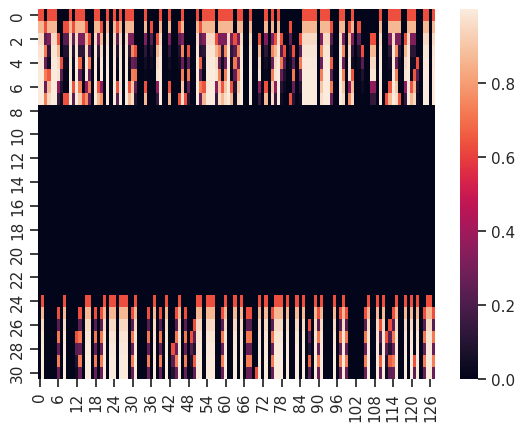

In [76]:
# /data/floyed/meta/train/PGPE-BatchedGruMLPPolicy-SeqTask--20230707-162644
resume = '/data/floyed/meta/train/PGPE-BatchedGruMLPPolicy-SeqTask--20230708-133249'
# resume = '/data/floyed/meta/train/PGPE-BatchedGruMLPPolicy-SeqTask--20230707-212239'  # use_bias = False
hidden_dims = [128]

train_task = SeqTask(
    seq_length=8,
    latency=16,
    batch_size=1,
    test=False
)
policy = getattr(evojax.policy, 'BatchedGruMLPPolicy')(
    input_dim=train_task.obs_shape[0],
    hidden_dims=[
        *hidden_dims,
    ],
    output_dim=train_task.act_shape[0],
)

best_params, obs_params, epoch, best_score, steps = load_model(model_dir=resume, fname='iter_200.npz')
obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape, dummy=True)

reset_rewards, reset_rollouts, reset_weight, reset_traces = eval_with_injury(seq, policy, obs_normalizer, best_params, obs_params, plot=True, seed=41, reset=True)
reset_traces = np.array(reset_traces[1:]).reshape(31, -1)
sns.heatmap(np.abs(reset_traces))

In [77]:
meta_spike = (np.abs(meta_traces) >= (1. - 1. / np.e))   # step, neuron
base_spike = (np.abs(base_traces) >= (1. - 1. / np.e))
reset_spike = (np.abs(reset_traces) >= (1. - 1. / np.e))

meta_traces_avg = np.abs(meta_traces).mean(axis=1)
base_traces_avg = np.abs(base_traces).mean(axis=1)
reset_traces_avg = np.abs(reset_traces).mean(axis=1)
meta_spike_avg = meta_spike.mean(axis=1)
base_spike_avg = base_spike.mean(axis=1)
reset_spike_avg = reset_spike.mean(axis=1)

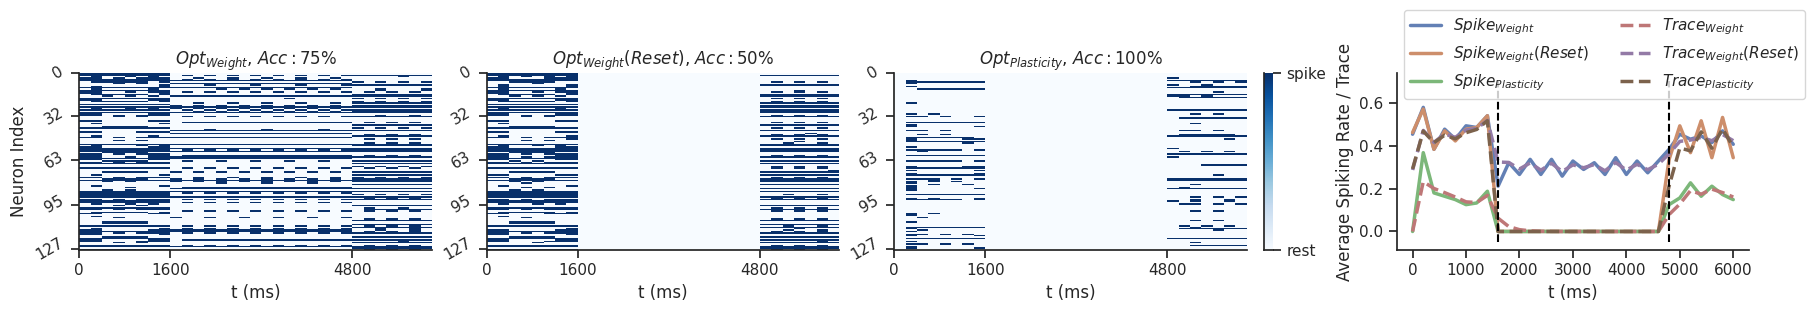

In [83]:
fig = plt.figure(figsize=(18, 3), dpi=100, constrained_layout=True)
spec = fig.add_gridspec(nrows=1, ncols=4, figure=fig)  # , width_ratios=[1, 1], height_ratios=[1, 1]

ax = fig.add_subplot(spec[0, 0])
sns.heatmap(base_spike.transpose(), ax=ax, cmap='Blues', cbar=False)
# cbar = ax.collections[0].colorbar
# cbar.set_ticks([0, 1])
# cbar.set_ticklabels(['rest', 'spike'])
# cbar.set_label('neuronal states')
ax.set_xticks([0, 8, 24], ['0', '1600', '4800'], rotation = 0)
ax.set_yticks([0, 31, 63, 95, 127], ['0', '32', '63', '95', '127'], rotation = 30)
ax.set_xlabel('t (ms)')
ax.set_ylabel('Neuron Index')
ax.set_title('$Opt_{Weight}$, $Acc: 75\%$')
sns.set_style("ticks")
sns.despine()


ax = fig.add_subplot(spec[0, 1])
sns.heatmap(reset_spike.transpose(), ax=ax, cmap='Blues', cbar=False)
# cbar = ax.collections[0].colorbar
# cbar.set_ticks([0, 1])
# cbar.set_ticklabels(['rest', 'spike'])
# cbar.set_label('neuronal states')
ax.set_xticks([0, 8, 24], ['0', '1600', '4800'], rotation = 0)
ax.set_yticks([0, 31, 63, 95, 127], ['0', '32', '63', '95', '127'], rotation = 30)
ax.set_xlabel('t (ms)')
ax.set_title('$Opt_{Weight}(Reset)$, $Acc: 50\%$')
sns.set_style("ticks")
sns.despine()

ax = fig.add_subplot(spec[0, 2])
sns.heatmap(meta_spike.transpose(), ax=ax, cmap='Blues')

cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['rest', 'spike'])
# cbar.set_label('neuronal states')
ax.set_xticks([0, 8, 24], ['0', '1600', '4800'], rotation = 0)
ax.set_yticks([0, 31, 63, 95, 127], ['0', '32', '63', '95', '127'], rotation = 30)
ax.set_xlabel('t (ms)')
ax.set_title('$Opt_{Plasticity}$, $Acc: 100\%$')
sns.set_style("ticks")
sns.despine()

ax = fig.add_subplot(spec[0, 3])
step = np.array(list(range(31))) * 200
ax.plot(step, base_spike_avg)
ax.plot(step, reset_spike_avg)
ax.plot(step, meta_spike_avg)
ax.plot(step, meta_traces_avg, '--')
ax.plot(step, base_traces_avg, '--')
ax.plot(step, reset_traces_avg, '--')
plt.legend(['$Spike_{Weight}$', '$Spike_{Weight}(Reset)$', '$Spike_{Plasticity}$', '$Trace_{Weight}$', '$Trace_{Weight}(Reset)$', '$Trace_{Plasticity}$'], ncol=2)
sns.set_style("ticks")
sns.despine()
plt.xlabel('t (ms)')
plt.ylabel('Average Spiking Rate / Trace')
sns.move_legend(ax, "upper left", bbox_to_anchor=(.0, 1.4), ncol=2)

plt.vlines([1600, 4800], [-.05, -.05], [0.70, 0.70], colors=['black', 'black'], linestyles='dashed', linewidths=[1.5, 1.5])

plt.savefig(os.path.join(output_dir, 'mem_act.pdf'), format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
seq = generate([1, 1, 1, 1, 0, 0, 0, 0])
meta_rewards, meta_rollouts, meta_weight, meta_traces = eval_with_injury(seq, policy, obs_normalizer, best_params, obs_params, plot=False, seed=41)

fig = plt.figure(figsize=(18, 6), dpi=100, constrained_layout=True)
spec = fig.add_gridspec(nrows=4, ncols=8, figure=fig)  # , width_ratios=[1, 1], height_ratios=[1, 1]

print(meta_weight[0].shape)   #  step,  i,  o

for idx, weight in enumerate(meta_weight[0]):
    ax = fig.add_subplot(spec[idx // 8, idx % 8])
    w = weight[0].reshape(16, 8)
    sns.heatmap(w, ax=ax, vmin=-1, vmax=1)

plt.show()

In [ ]:
seq = generate([0, 0, 0, 0, 0, 0, 0, 0])
meta_rewards, meta_rollouts, meta_weight, meta_traces = eval_with_injury(seq, policy, obs_normalizer, best_params, obs_params, plot=False, seed=41)

fig = plt.figure(figsize=(18, 6), dpi=100, constrained_layout=True)
spec = fig.add_gridspec(nrows=4, ncols=8, figure=fig)  # , width_ratios=[1, 1], height_ratios=[1, 1]

print(meta_weight[0].shape)   #  step,  i,  o

for idx, weight in enumerate(meta_weight[0]):
    ax = fig.add_subplot(spec[idx // 8, idx % 8])
    w0 = meta_weight[0][7, 0].reshape(16, 8)
    w1 = meta_weight[1][7].reshape(16, 8)
    w = np.concatenate([w0, w1], axis=-1)
    sns.heatmap(w, ax=ax, vmin=-1, vmax=1)

plt.show()

In [ ]:
seq = generate([0, 0, 0, 0, 0, 0, 0, 0])
meta_rewards, meta_rollouts, meta_weight, meta_traces = eval_with_injury(seq, policy, obs_normalizer, best_params, obs_params, plot=False, seed=41)

print(meta_weight[0].shape)   #  step,  i,  o
w0 = meta_weight[0][7, 0].reshape(16, 8)
w1 = meta_weight[1][7].reshape(16, 8)
_w = np.concatenate([w0, w1], axis=-1)


fig = plt.figure(figsize=(12, 2), dpi=100, constrained_layout=True)
spec = fig.add_gridspec(nrows=2, ncols=6, figure=fig, height_ratios=[1, 0.06])  # , width_ratios=[1, 1], height_ratios=[1, 1]

seqs = [
    [0, 0, 0, 0, 0, 0, 0, 1],
    [0, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 0, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 0],
    # [1, 1, 1, 0, 1, 1, 1, 1],
    # [1, 1, 1, 1, 1, 1, 1, 1],
]

title = [
    '00000001',
    '01111111',
    '11110111',
    '11111110',
]

for idx, seq in enumerate(seqs):
    seq = generate(seq)
    meta_rewards, meta_rollouts, meta_weight, meta_traces = eval_with_injury(seq, policy, obs_normalizer, best_params, obs_params, plot=False, seed=41)

    ax = fig.add_subplot(spec[idx])
    w0 = meta_weight[0][7, 0].reshape(16, 8)
    w1 = meta_weight[1][7].reshape(16, 8)
    w = np.concatenate([w0, w1], axis=-1)
    sns.heatmap(w - _w, ax=ax, vmin=-1, vmax=1, cbar=False if idx != 3 else True, cmap=plt.cm.seismic)
    ax.set_xticks([0, 8, 16], ['0', '128', '256'], rotation = 0)
    if idx == 0:
        ax.set_yticks([0 ,4 ,8, 12, 16], ['0', '4', '8', '12', '16'])
    else:
        ax.set_yticks([])
    ax.set_title('{}'.format(title[idx]))
    plt.axvline(8, ls='--', c='k')
    if idx == 3:
        cbar = ax.collections[0].colorbar
        cbar.set_label('$weight$')
    sns.set_style("ticks")
    sns.despine()

fig.text(0.27, 0.0, 'Neuron Index', va='center')
plt.savefig(os.path.join(output_dir, 'weight_change.pdf'), format='pdf', bbox_inches='tight')
plt.show()

## Cue-Reward

In [ ]:
meta_dir = [
    '/data/floyed/meta/train/PGPE-BatchedGruMetaStdpMLPPolicy-CueRewardTask--20230708-235123',
    '/data/floyed/meta/train/PGPE-BatchedGruMetaStdpMLPPolicy-CueRewardTask--20230708-235237',
    '/data/floyed/meta/train/PGPE-BatchedGruMetaStdpMLPPolicy-CueRewardTask--20230708-235227',
]

base_dir = [
    '/data/floyed/meta/train/PGPE-BatchedGruMLPPolicy-CueRewardTask--20230708-235123',
    '/data/floyed/meta/train/PGPE-BatchedGruMLPPolicy-CueRewardTask--20230709-004356',
    '/data/floyed/meta/train/PGPE-BatchedGruMLPPolicy-CueRewardTask--20230709-004404',
]


fig = plt.figure(figsize=(9, 6), dpi=100, constrained_layout=True)
spec = fig.add_gridspec(nrows=5, ncols=6, figure=fig, width_ratios=[0.1, 1, 1, 1, 1, 1], height_ratios=[1, 1, 1, 1, 0.1])

data = []
for fname in base_dir:
    df = pd.read_csv(os.path.join(fname, 'summary.csv'))
    df['Score'] = df['score_avg']
    df['episode'] = df['epoch']
    df['Method'] = '$Opt_{Weight}$'
    data.append(df)

for fname in meta_dir:
    df = pd.read_csv(os.path.join(fname, 'summary.csv'))
    df['Score'] = df['score_avg']
    df['episode'] = df['epoch']
    df['Method'] = '$Opt_{Plasticity}$'
    data.append(df)

data = pd.concat(data)
data.drop(data[data['epoch'] == 'epoch'].index, inplace=True)
data[['epoch', 'seq_length', 'episode']] = data[['epoch', 'seq_length', 'episode']].astype(int)
data[['score_avg', 'score_best', 'score_std', 'Score', 'sigma']] = data[['score_avg', 'score_best', 'score_std', 'Score', 'sigma']].astype(float)
data = data.reset_index(drop=True)

r, c = 0, 0
for seq_length in [16, 32, 48, 64]:
    for sigma in [0, 0.3, 0.38, 0.48, 0.59]:
        print('Seq_length: {}, Sigma: {}'.format(seq_length, sigma))
        print('Plasticity:')
        print(data[(data['epoch'] == 11999) & (data['Method'] == '$Opt_{Plasticity}$') & (data['seq_length'] == seq_length) & (data['sigma'] == sigma)]['Score'].mean())
        print(data[(data['epoch'] == 11999) & (data['Method'] == '$Opt_{Plasticity}$') & (data['seq_length'] == seq_length) & (data['sigma'] == sigma)]['Score'].std())
        print('Weight:')
        print(data[(data['epoch'] == 11999) & (data['Method'] == '$Opt_{Weight}$') & (data['seq_length'] == seq_length) & (data['sigma'] == sigma)]['Score'].mean())
        print(data[(data['epoch'] == 11999) &( data['Method'] == '$Opt_{Weight}$') & (data['seq_length'] == seq_length) & (data['sigma'] == sigma)]['Score'].std())

        ax = fig.add_subplot(spec[r, c + 1])
        sns.lineplot(data=data[(data['seq_length'] == seq_length) & (data['sigma'] == sigma)], x='episode', y='Score', hue='Method', legend=None if r != 0 or c != 0 else 'auto')
        sns.despine()
        plt.xlabel('')
        plt.ylabel('')
        plt.title('Len: {}, Sigma: {}'.format(seq_length, sigma))
        # plt.xlim(0, 11999)
        # plt.ylim(.5, 1.)
        sns.set_style("ticks")

        c = (c + 1) % 5
    r += 1

fig.text(0.5, 0.0, 'episode', va='center')
fig.text(0.0, 0.5, 'Accuracy', va='center', rotation='vertical')
# fig.text(0.0, 1.0, 'Seq_len / sigma', va='center')
plt.savefig(os.path.join(output_dir, 'cue_reward_vis.pdf'), format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# /data/floyed/meta/train/PGPE-BatchedGruMetaStdpMLPPolicy-SeqTask--20230706-212038
resume = '/data/floyed/meta/train/PGPE-BatchedGruMetaStdpMLPPolicy-CueRewardTask--20230709-004524'
hidden_dims = [128]

train_task = CueRewardTask(
    seq_length=8,
    latency=16,
    batch_size=1,
    test=False
)
policy = getattr(evojax.policy, 'BatchedGruMetaStdpMLPPolicy')(
    input_dim=train_task.obs_shape[0],
    hidden_dims=[
        *hidden_dims,
    ],
    output_dim=train_task.act_shape[0],
)

best_params, obs_params, epoch, best_score, steps = load_model(model_dir=resume)
obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape, dummy=True)

seq = generate([1, 1, 1, 1, 1, 1, 1, 1])
meta_rewards, meta_rollouts, meta_weight, meta_traces = eval_with_injury(seq, policy, obs_normalizer, best_params, obs_params, plot=True, seed=41)
meta_traces = np.array(meta_traces[1:]).reshape(31, -1)
sns.heatmap(np.abs(meta_traces))


resume = '/data/floyed/meta/train/PGPE-BatchedGruMLPPolicy-CueRewardTask--20230709-003042'
hidden_dims = [128]

train_task = SeqTask(
    seq_length=8,
    latency=16,
    batch_size=1,
    test=False
)
policy = getattr(evojax.policy, 'BatchedGruMLPPolicy')(
    input_dim=train_task.obs_shape[0],
    hidden_dims=[
        *hidden_dims,
    ],
    output_dim=train_task.act_shape[0],
)

best_params, obs_params, epoch, best_score, steps = load_model(model_dir=resume, fname='iter_100.npz')
obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape, dummy=True)

# base_seq = generate([0, 1, 0, 1])
base_rewards, base_rollouts, base_weight, base_traces = eval_with_injury(seq, policy, obs_normalizer, best_params, obs_params, plot=True, seed=41)
base_traces = np.array(base_traces[1:]).reshape(31, -1)
sns.heatmap(np.abs(base_traces))